In [2]:
# Basic imports
import geopandas as gpd
from pathlib import Path

# Library imports
from multiview_mapping_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.geospatial import ensure_geometric_CRS
from multiview_mapping_toolkit.constants import (
    EXAMPLE_LABELS_FILENAME,
    EXAMPLE_MESH_FILENAME,
    EXAMPLE_CAMERAS_FILENAME,
    EXAMPLE_DTM_FILE,
    EXAMPLE_IMAGE_FOLDER,
    EXAMPLE_STANDARDIZED_LABELS_FILENAME,
    EXAMPLE_LABELED_MESH_FILENAME,
    EXAMPLE_RENDERED_LABELS_FOLDER,
    TWENTY_CLASS_VIS_KWARGS,
)

# Set constants
You should be able to define most of the behavior from these constants

In [3]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = True
# Points less than this height above the DTM are considered ground
# Something is off about the elevation between the mesh and the DTM, this should be a threshold in meters above ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METER = 50
# Tree Radius
TREE_RADIUS_METERS = 2.5
# Downsample target
DOWNSAMPLE_TARGET = 0.1

## Define the inputs
# The input labels
LABELS_FILENAME = EXAMPLE_LABELS_FILENAME
# Textures filename
LABEL_COLUMN_NAME = "Species"
# The mesh exported from Metashape
MESH_FILENAME = EXAMPLE_MESH_FILENAME
# The camera file exported from Metashape
CAMERAS_FILENAME = EXAMPLE_CAMERAS_FILENAME
# The digital elevation map exported by Metashape
DTM_FILE = EXAMPLE_DTM_FILE
# The image folder used to create the Metashape project
IMAGE_FOLDER = EXAMPLE_IMAGE_FOLDER

## Define the intermediate results
# Processed geo file
STANDARDIZED_LABELS_FILENAME = EXAMPLE_STANDARDIZED_LABELS_FILENAME
# Where to save the mesh after labeling
LABELED_MESH_FILENAME = EXAMPLE_LABELED_MESH_FILENAME
# Where to save the rendering label images
RENDER_FOLDER = EXAMPLE_RENDERED_LABELS_FOLDER

# Geospatial processing

Preprocess the geospatial data to be as expected.

<Axes: >

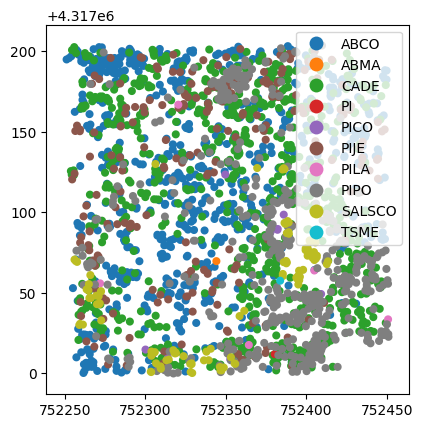

In [4]:
# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
# Ensure that the CRS is geometric so we can buffer
gdf = ensure_geometric_CRS(gdf)

# Now create circles around each point
gdf["geometry"] = gdf["geometry"].buffer(TREE_RADIUS_METERS)

# Split
gdf = gdf.dissolve(LABEL_COLUMN_NAME, as_index=False)
# Drop all but the geometry and the species label
gdf = gdf.loc[:, gdf.columns.intersection([LABEL_COLUMN_NAME, "geometry"])]
# Write out the sandarized file
gdf.to_file(STANDARDIZED_LABELS_FILENAME)
# Show
gdf.plot(LABEL_COLUMN_NAME, legend=True)

# Load the mesh and read texture from geopolygon

In [5]:
# Create a labeled version of the mesh from the field data
# if not present or requested
if not Path(LABELED_MESH_FILENAME).is_file() or RETEXTURE:
    # Load the downsampled mesh and apply the texture from the vector file
    mesh = TexturedPhotogrammetryMesh(
        MESH_FILENAME,
        downsample_target=DOWNSAMPLE_TARGET,
        texture=STANDARDIZED_LABELS_FILENAME,
        texture_column_name=LABEL_COLUMN_NAME,
        transform_filename=CAMERAS_FILENAME,
    )
    # Get the vertex textures from the mesh
    texture_verts = mesh.get_texture(
        request_vertex_texture=True, try_verts_faces_conversion=False
    )
    mesh.label_ground_class(
        DTM_file=DTM_FILE,
        height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
        only_label_existing_labels=True,
        ground_class_name="GROUND",
        set_mesh_texture=True,
    )

    mesh.save_mesh(LABELED_MESH_FILENAME, save_vert_texture=True)
else:
    mesh = TexturedPhotogrammetryMesh(
        LABELED_MESH_FILENAME, transform_filename=CAMERAS_FILENAME
    )

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Downsampling the mesh
Extracting faces from mesh
Loading texture
Could not read texture as a scalar from the pyvista mesh
Could not read texture as a numpy file


Sampling values from raster /ofo-share/repos-rahul/multiview-mapping-toolkit/data/example_Emerald_Point_data/inputs/dtm.tif: 100%|██████████| 71620/71620 [00:03<00:00, 22653.27it/s]


# Load a set of cameras and downsample them to the region around annotations

In [6]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=STANDARDIZED_LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METER
)
training_camera_set.vis(force_xvfb=True, frustum_scale=0.5)

Loading GPS data for camera set: 100%|██████████| 915/915 [00:00<00:00, 1028897.63it/s]
/ofo-share/repos-rahul/envs/MVMT-Rahul5/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


Widget(value="<iframe src='http://localhost:43277/index.html?ui=P_0x7fa5b1f5ef40_0&reconnect=auto' style='widt…

# Show the mesh

This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices
This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


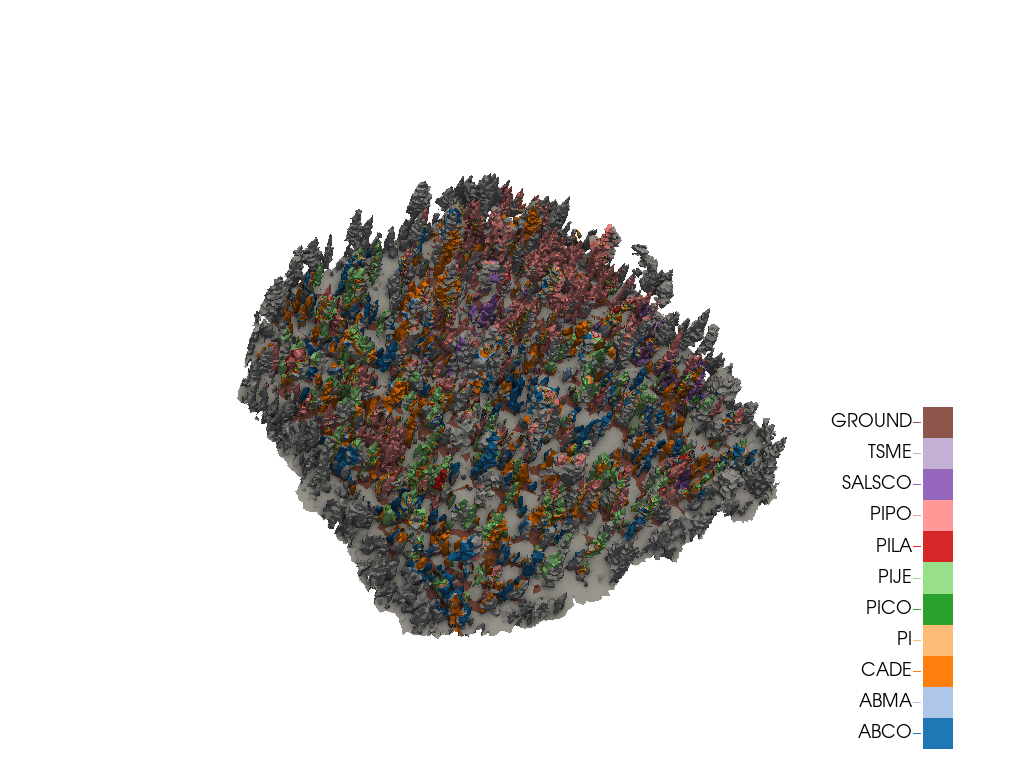

In [7]:
# You can include the camera set, but it's cleaner without it
mesh.vis(camera_set=None, force_xvfb=True)

# Render the labels onto the images

In [7]:
mesh.save_renders_pytorch3d(
    camera_set=training_camera_set,
    render_image_scale=RENDER_IMAGE_SCALE,
    save_native_resolution=True,
    output_folder=RENDER_FOLDER,
)

Saving renders to /ofo-share/repos-rahul/multiview-mapping-toolkit/data/example_Emerald_Point_data/intermediate_results/rendered_labels
Saving IDs_to_labels to /ofo-share/repos-rahul/multiview-mapping-toolkit/data/example_Emerald_Point_data/intermediate_results/rendered_labels/IDs_to_labels.json


Saving renders: 100%|██████████| 778/778 [06:25<00:00,  2.02it/s]


# Show some of the rendered labels

ValueError: ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b'] is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

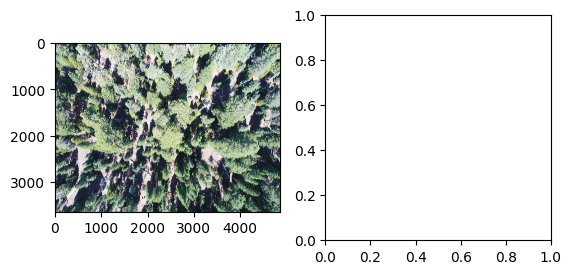

In [8]:
from multiview_mapping_toolkit.utils.visualization import show_segmentation_labels

show_segmentation_labels(
    label_folder=RENDER_FOLDER,
    image_folder=IMAGE_FOLDER,
    num_show=10,
    imshow_kwargs=TWENTY_CLASS_VIS_KWARGS,
)